# Group project Machine Learning on other drug abuse
By: Yutong (Adapted from Jing's source code)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pandas_profiling as pp
import joblib
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from lightgbm import LGBMClassifier
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix

# Load data

In [2]:
tp = pd.read_csv('NSDUH_2018_Tab.tsv', sep='\t', iterator=True, chunksize=1000, low_memory=False)
df = pd.concat(tp, ignore_index=True)
df.head()

,QUESTID2,FILEDATE,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
0,11015143,10/08/2019,1,99,99,12,9999,99,1,20,...,3.0,2,2,1,1,2,2,20783.261908,40001,1
1,86325143,10/08/2019,2,99,99,991,9991,91,91,91,...,2.0,2,2,3,3,2,2,1095.884074,40004,1
2,35425143,10/08/2019,1,99,99,13,9999,99,4,93,...,3.0,2,2,2,2,2,2,374.445005,40017,2
3,98125143,10/08/2019,2,99,99,991,9991,91,91,91,...,2.0,2,2,2,2,2,2,2421.263435,40038,2
4,15945143,10/08/2019,2,99,99,991,9991,91,91,91,...,2.0,1,2,1,1,2,2,6637.319591,40040,2


# Data Wrangling

Check if data has duplicated records

In [3]:
dfmarijuana = df["MJYRTOT"]
dfmarijuana


0        991
1        991
2          5
3        991
4        991
        ... 
56308    991
56309    260
56310    991
56311    300
56312    991
Name: MJYRTOT, Length: 56313, dtype: int64

RANGE = 1 - 365 
985 = BAD DATA Logically assigned 
991 = NEVER USED MARIJUANA 
993 = DID NOT USE MARIJUANA IN THE PAST 12 MOS .
994 = DON'T KNOW  
997 = REFUSED 
998 = BLANK (NO ANSWER)

In [4]:
# drop the useless data of marijuana use according to the codebook
dropdata = [985, 994, 997, 998]
df = df[~df.MJYRTOT.isin(dropdata)]


### MJYRTOT (TOTAL # OF DAYS USED MARIJUANA IN PAST 12 MOS) (codebook 64)
RANGE = 1 - 365 
- 985 = BAD DATA Logically assigned 
- 991 = NEVER USED MARIJUANA 
- 993 = DID NOT USE MARIJUANA IN THE PAST 12 MOS .
- 994 = DON'T KNOW  
- 997 = REFUSED 
- 998 = BLANK (NO ANSWER)

### CIGEVER (EVER SMOKED A CIGARETTE) (codebook 4)
- 1 = Yes
- 2 = No
### ALCEVER (EVER HAD DRINK OF ALCOHOLIC BEVERAGE) (codebook17)
- 1 = Yes  
- 2 = No 
- 85 = BAD DATA Logically assigned 
- 94 = DON'T KNOW
- 97 = REFUSED
### CRKEVER (EVER USED CRACK) (codebook 30)
- 1 = Yes  
- 2 = No
- 91 = NEVER USED COCAINE (COCEVER=2)
- 94 = DON'T KNOW
- 97 = REFUSED
- 98 = BLANK (NO ANSWER)
### HEREVER (EVER USED HEROIN) (codebook34)
- 1 = Yes
- 2 = No 
- 94 = DON'T KNOW 
- 97 = REFUSED
### COCEVER (EVER USED COCAINE) (codebook 26)
- 1 = Yes 
- 2 = No 
- 85 = BAD DATA Logically assigned 
- 94 = DON'T KNOW
- 97 = REFUSED
### METHAMEVR (EVER USED METHAMPHETAMINE) (codebook 62)
- 1 = Yes  
- 2 = No  
- 94 = DON'T KNOW
- 97 = REFUSED

In [5]:
# select all the features we need from the codebook, more details on the features are available in the Codebook.ipynb
df1 = df[["QUESTID2","IREDUHIGHST2","IRWRKSTAT","MJYRTOT","SEXIDENT","HEALTH2","WRKDRGEDU","YELSTGRD","YEYATTAK","YERLGIMP",'ALCEVER']]
df1.head()

,QUESTID2,IREDUHIGHST2,IRWRKSTAT,MJYRTOT,SEXIDENT,HEALTH2,WRKDRGEDU,YELSTGRD,YEYATTAK,YERLGIMP,ALCEVER
0,11015143,8,1,991,1,3.0,1,99,99,99,1
1,86325143,11,1,991,1,3.0,2,99,99,99,1
2,35425143,8,2,5,3,3.0,2,99,99,99,1
3,98125143,9,4,991,1,3.0,99,99,99,99,1
4,15945143,7,1,991,1,3.0,2,99,99,99,1


# Check if there are duplicated records

In [6]:
#check if data has duplicates
df1_duplicate = df1[df1.duplicated(keep = 'first')]
duplicate_rate = df1_duplicate.shape[0] / df1.shape[0]
print('%d rows (%.2f) are duplicates' % (df1_duplicate.shape[0], duplicate_rate))

0 rows (0.00) are duplicates


# Check if data has missing values

In [7]:
print(df1.isnull().sum())

QUESTID2         0
IREDUHIGHST2     0
IRWRKSTAT        0
MJYRTOT          0
SEXIDENT         0
HEALTH2         13
WRKDRGEDU        0
YELSTGRD         0
YEYATTAK         0
YERLGIMP         0
ALCEVER          0
dtype: int64


In [9]:
df1.fillna(df1.mean(), inplace=True)

In [10]:
df1

,QUESTID2,IREDUHIGHST2,IRWRKSTAT,MJYRTOT,SEXIDENT,HEALTH2,WRKDRGEDU,YELSTGRD,YEYATTAK,YERLGIMP,ALCEVER
0,11015143,8,1,991,1,3.0,1,99,99,99,1
1,86325143,11,1,991,1,3.0,2,99,99,99,1
2,35425143,8,2,5,3,3.0,2,99,99,99,1
3,98125143,9,4,991,1,3.0,99,99,99,99,1
4,15945143,7,1,991,1,3.0,2,99,99,99,1
...,...,...,...,...,...,...,...,...,...,...,...
56308,71224730,5,2,991,99,2.0,2,2,1,4,1
56309,69424730,7,2,260,99,2.0,1,2,1,1,1
56310,13024730,9,2,991,1,1.0,2,99,99,99,1
56311,85634730,8,1,300,1,2.0,2,99,99,99,1


In [11]:
df1 = df1.drop("QUESTID2", axis=1)
df1["IRWRKSTAT"] = df1["IRWRKSTAT"].apply(lambda x: 5 if x > 4 else x)
df1['MJYRTOT'] = df1['MJYRTOT'].apply(lambda x: 1 if x < 366 else 0)
df1['ALCEVER'] = df1['ALCEVER'].apply(lambda x: 1 if x == 1 else 0)

In [12]:
corr_table = df1.corr(method='pearson')
corr_table

,IREDUHIGHST2,IRWRKSTAT,MJYRTOT,SEXIDENT,HEALTH2,WRKDRGEDU,YELSTGRD,YEYATTAK,YERLGIMP,ALCEVER
IREDUHIGHST2,1.000000,-0.603464,0.108543,-0.722664,-0.017630,-0.482509,0.695537,0.734167,0.717662,0.542008
IRWRKSTAT,-0.603464,1.000000,-0.122648,0.558321,0.027943,0.912587,-0.538510,-0.567138,-0.554094,-0.459382
MJYRTOT,0.108543,-0.122648,1.000000,-0.101892,0.057132,-0.102532,0.090625,0.099389,0.094814,0.259742
SEXIDENT,-0.722664,0.558321,-0.101892,1.000000,-0.124455,0.446235,-0.915381,-0.954873,-0.940141,-0.553972
HEALTH2,-0.017630,0.027943,0.057132,-0.124455,1.000000,0.064752,0.139034,0.136577,0.135143,0.092287
WRKDRGEDU,-0.482509,0.912587,-0.102532,0.446235,0.064752,1.000000,-0.411330,-0.433719,-0.423878,-0.376475
YELSTGRD,0.695537,-0.538510,0.090625,-0.915381,0.139034,-0.411330,1.000000,0.956192,0.949386,0.524236
YEYATTAK,0.734167,-0.567138,0.099389,-0.954873,0.136577,-0.433719,0.956192,1.000000,0.982103,0.553305
YERLGIMP,0.717662,-0.554094,0.094814,-0.940141,0.135143,-0.423878,0.949386,0.982103,1.000000,0.540895
ALCEVER,0.542008,-0.459382,0.259742,-0.553972,0.092287,-0.376475,0.524236,0.553305,0.540895,1.000000


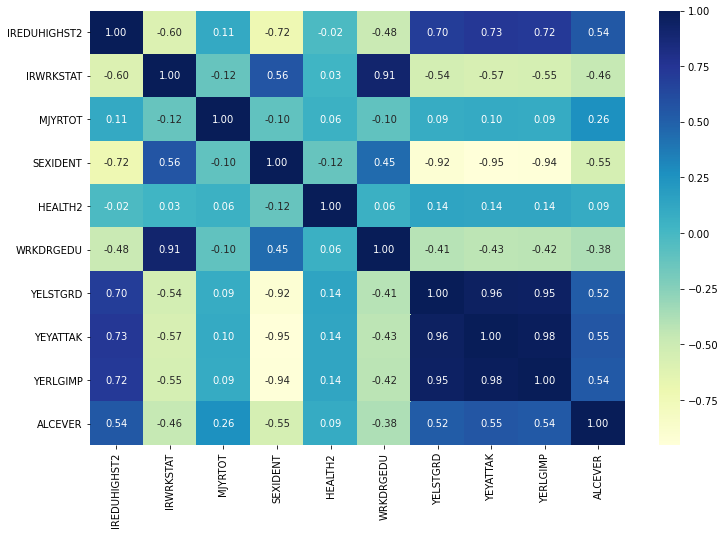

In [13]:
%matplotlib inline
f = plt.figure(figsize=(12,8))
corr_table = df1.corr(method='pearson')
sns.heatmap(corr_table,cmap='YlGnBu', annot=True, fmt=".2f")
plt.show()


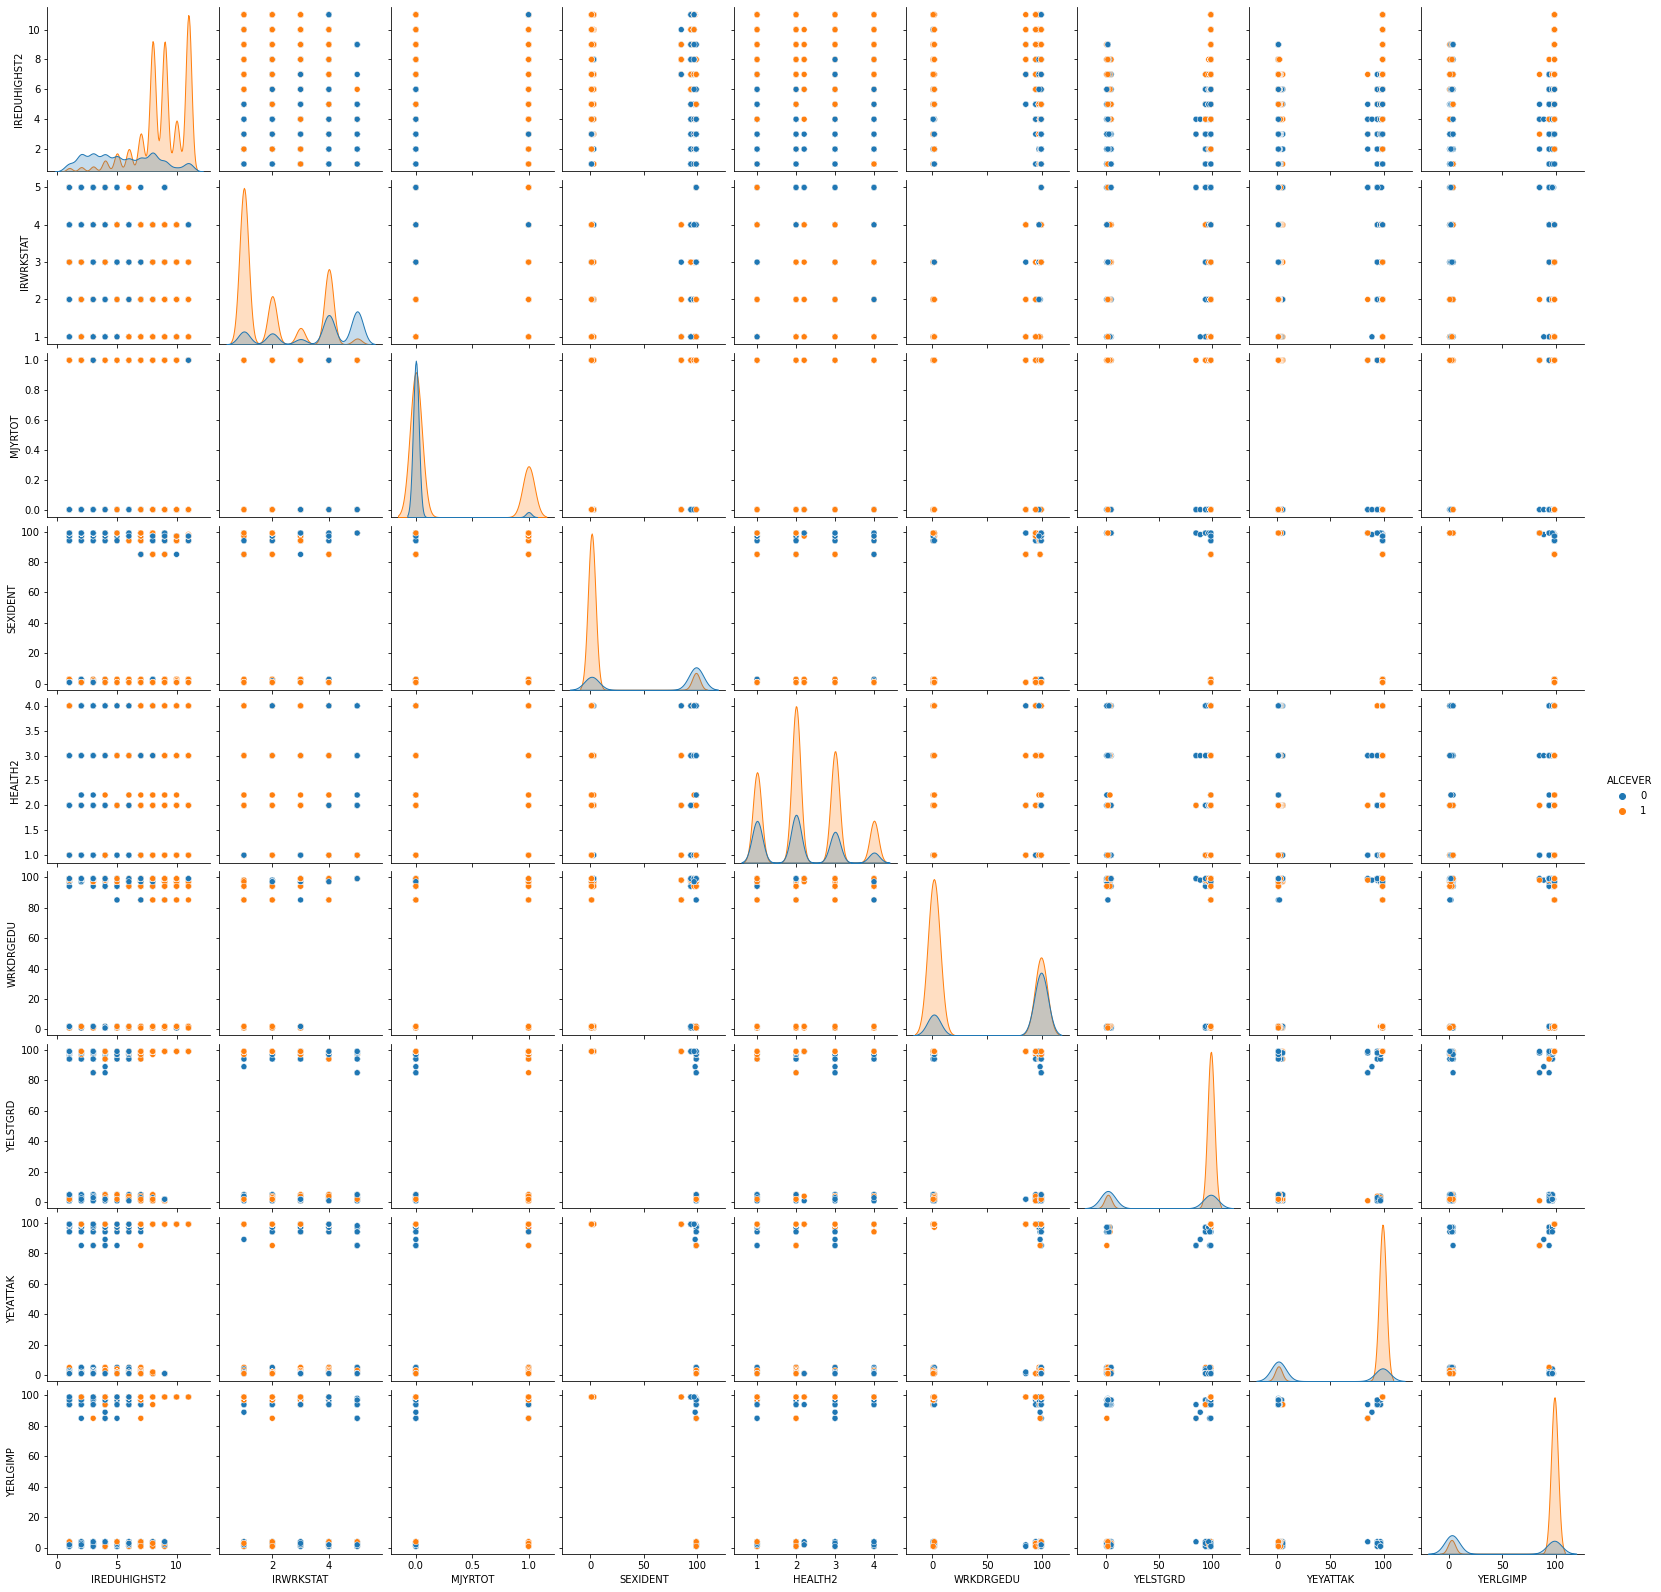

In [15]:
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

sns.pairplot(df1, hue = 'ALCEVER')
plt.show()

# Build Machine Learning Model

In [14]:
# Separate dataset
y = df1['ALCEVER']
x = df1.drop('ALCEVER', axis=1)

In [15]:
y

0        1
1        1
2        1
3        1
4        1
        ..
56308    1
56309    1
56310    1
56311    1
56312    1
Name: ALCEVER, Length: 55832, dtype: int64

In [16]:
x

,IREDUHIGHST2,IRWRKSTAT,MJYRTOT,SEXIDENT,HEALTH2,WRKDRGEDU,YELSTGRD,YEYATTAK,YERLGIMP
0,8,1,0,1,3.0,1,99,99,99
1,11,1,0,1,3.0,2,99,99,99
2,8,2,1,3,3.0,2,99,99,99
3,9,4,0,1,3.0,99,99,99,99
4,7,1,0,1,3.0,2,99,99,99
...,...,...,...,...,...,...,...,...,...
56308,5,2,0,99,2.0,2,2,1,4
56309,7,2,1,99,2.0,1,2,1,1
56310,9,2,0,1,1.0,2,99,99,99
56311,8,1,1,1,2.0,2,99,99,99


In [17]:
# standard scaler
sc = StandardScaler()
x_sc = sc.fit_transform(x)

In [18]:
x_sc

array([[ 0.05380506, -1.00805086, -0.49253305, ...,  0.52922636,
         0.55205837,  0.54354114],
       [ 1.16067461, -1.00805086, -0.49253305, ...,  0.52922636,
         0.55205837,  0.54354114],
       [ 0.05380506, -0.34959522,  2.03032062, ...,  0.52922636,
         0.55205837,  0.54354114],
       ...,
       [ 0.42276157, -0.34959522, -0.49253305, ...,  0.52922636,
         0.55205837,  0.54354114],
       [ 0.05380506, -1.00805086,  2.03032062, ...,  0.52922636,
         0.55205837,  0.54354114],
       [ 0.79171809, -1.00805086, -0.49253305, ...,  0.52922636,
         0.55205837,  0.54354114]])

In [19]:
x

,IREDUHIGHST2,IRWRKSTAT,MJYRTOT,SEXIDENT,HEALTH2,WRKDRGEDU,YELSTGRD,YEYATTAK,YERLGIMP
0,8,1,0,1,3.0,1,99,99,99
1,11,1,0,1,3.0,2,99,99,99
2,8,2,1,3,3.0,2,99,99,99
3,9,4,0,1,3.0,99,99,99,99
4,7,1,0,1,3.0,2,99,99,99
...,...,...,...,...,...,...,...,...,...
56308,5,2,0,99,2.0,2,2,1,4
56309,7,2,1,99,2.0,1,2,1,1
56310,9,2,0,1,1.0,2,99,99,99
56311,8,1,1,1,2.0,2,99,99,99


In [20]:
# split training dataset
x_train, x_validate, y_train, y_validate = train_test_split(x_sc, y, test_size=0.3, random_state= 0)

In [22]:
#define random forest function
def SVCClassifier(x_train, y_train):
    clf = SVC(kernel = 'linear', probability=True)
    clf.fit(x_train, y_train)
    return (clf)

In [23]:
#Function to make predictions

def prediction(x_validate, clf):
    y_pred = clf.predict(x_validate)
    y_prob = clf.predict_proba(x_validate)
    
    return y_pred, y_prob
    

In [24]:
# Calculate Accuracy

def cal_accuracy(y_validate, y_pred):
    conf_mtx = confusion_matrix(y_validate, y_pred)
    accuracy = accuracy_score(y_validate, y_pred) * 100
    report = classification_report(y_validate, y_pred)
    print("Confusion Matrix", conf_mtx)
    print("Accuracy:", accuracy)
    print("Report:", report)
    return conf_mtx
    

In [25]:
# train with clf model
clf = SVCClassifier(x_train, y_train)

#cross validation
scores = cross_val_score(clf, x_sc, y, cv=5)
print('cross validation score:', scores)

cross validation score: [0.84561655 0.84346736 0.84157263 0.84631918 0.84990149]


In [26]:
#run prediction
y_pred = prediction(x_validate, clf)[0]
y_pred


array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [29]:
cal_accuracy(y_validate, y_pred)

Confusion Matrix [[ 2786  1949]
 [  618 11397]]
Accuracy: 84.67462686567164
Report:               precision    recall  f1-score   support

           0       0.82      0.59      0.68      4735
           1       0.85      0.95      0.90     12015

    accuracy                           0.85     16750
   macro avg       0.84      0.77      0.79     16750
weighted avg       0.84      0.85      0.84     16750



array([[ 2786,  1949],
       [  618, 11397]], dtype=int64)

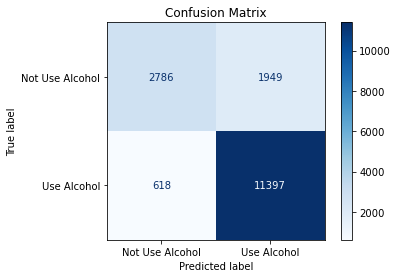

In [35]:
#Plot non-normalized confusion matrix
%matplotlib inline
disp = plot_confusion_matrix(clf, x_validate, y_validate,
                             display_labels = ("Not Use Alcohol", "Use Alcohol"),
                             values_format='d',
                             cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
#Feature importance
%matplotlib inline
def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(len(names)),imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show
    
    
    
    
    
 

In [ ]:
#show all features
features_names = ["QUESTID2","IREDUHIGHST2","IRWRKSTAT","MJYRTOT","SEXIDENT","HEALTH2","WRKDRGEDU","YELSTGRD","YEYATTAK","YERLGIMP"]
svm = svm.SVC(kernel='linear')
svm.fit(x_train, y_train)
Featureimportance = f_importances(svm.coef, features_names)
Featureimportance

In [ ]:
#ROC Analysis using Cross Validation
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots(figsize=(12, 8))
for i, (train, test) in enumerate(cv.split(x_train, y_train)):
    clf.fit(x_train, y_train)
    viz = plot_roc_curve(clf, x_validate, y_validate, 
                         name='ROC fold {}'.format(i), 
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
fig.tight_layout()
